In [2]:
!pip install datasets

In [3]:
import torch, torchdata, torchtext
import torch.nn as nn
import datasets
import gc
import torch.nn.functional as F
from numpy.random import default_rng
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [5]:
import numpy as np
import pandas as pd
import os
import chardet

In [6]:
torch.__version__

'2.1.0+cu121'

In [7]:
torchtext.__version__

'0.16.0+cpu'

### 1. Load Dataset


In [8]:
from datasets import load_dataset
dataset = load_dataset("opus100",'en-ne')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/406381 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 406381
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})

## 2. EDA

In [12]:
sample = next(iter(dataset['train']))
sample

{'ne': 'मिलेका रेखाहरुको माथि पिक्सलहरु', 'en': 'Pixels above lines set'}

In [13]:
train_size = len(list(iter(dataset['train'])))
train_size

200000

In [14]:
dataset

DatasetDict({
    test: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['ne', 'en'],
        num_rows: 2000
    })
})

## 3. Preprocessing: Tokenizer




In [15]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [61]:
source = 'en'
target = 'ne'

In [62]:
!pip install nepalitokenizers

In [63]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 33.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [65]:
token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
# This line above initializes a tokenizer for English using spaCy.

token_transform["ne"] = WordPiece()
# This line above initializes a WordPiece tokenizer.


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [66]:
print("Sentence: ", dataset['train']['ne'][2])
print("Tokenization: ", token_transform['ne'].encode(dataset['train']['ne'][2]).tokens)

Sentence:  क्लिपबोर्ड साइन गर्न सकिएन ।
Tokenization:  ['[CLS]', 'क्लि', '##प', '##बोर्ड', 'साइन', 'गर्न', 'सकिएन', '।', '[SEP]']


In [67]:
def tokenize_the_data(data, lang):
    try:
        if lang in token_transform:
            tokenized_data = token_transform[lang](data[lang].lower())
            return {lang: tokenized_data}
    except Exception as e:
        print(f"Error occurred while tokenizing {lang} data: {e}")
    return None

# Tokenize the source language data
tokenized_source_dataset = dataset.map(
    lambda data: tokenize_the_data(data, source),
    remove_columns=[source],
    fn_kwargs={'lang': source}
)

# Tokenize the target language data
tokenized_target_dataset = tokenized_source_dataset.map(
    lambda data: tokenize_the_data(data, target),
    remove_columns=[target],
    fn_kwargs={'lang': target}
)


Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [68]:
# Define indices for special tokens
UNK_IDX = 0  # Unknown token index
PAD_IDX = 1  # Padding token index
SOS_IDX = 2  # Start of sequence token index
EOS_IDX = 3  # End of sequence token index

# Define special symbols
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Comment: These indices and symbols are often used in natural language processing tasks,
# where <unk> represents an unknown token, <pad> represents padding in sequences,
# <sos> represents the start of a sequence, and <eos> represents the end of a sequence.


In [69]:
# Import the necessary function
from torchtext.vocab import build_vocab_from_iterator

# Iterate over source and target languages
for ln in [source, target]:
    # Build vocabulary from the tokenized dataset
    # with minimum frequency of 2
    # including special symbols, with special symbols first
    vocab_transform[ln] = build_vocab_from_iterator(
        tokenized_dataset['train'][ln],
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

# Iterate again over source and target languages
for ln in [source, target]:
    # Set the default index for the vocabulary to UNK_IDX
    vocab_transform[ln].set_default_index(UNK_IDX)


In [70]:
torch.save(vocab_transform, 'vocab')

## 4. Data loader

In [77]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Function to apply sequential transformations to text input
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            try:
                txt_input = transform(txt_input)
            except:
                # If an error occurs, attempt to encode the text input
                txt_input = transform.encode(txt_input).tokens
        return txt_input
    return func

# Function to add special tokens and convert token IDs to tensors
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))

# Dictionary to store text transformations for each language
text_transform = {}
for ln in [source, target]:
    # Apply sequential transformations: tokenization, numericalization, adding special tokens
    text_transform[ln] = sequential_transforms(token_transform[ln], vocab_transform[ln], tensor_transform)

# Function to collate data samples into batch tensors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        # Apply text transformation to source and target samples
        processed_text = text_transform[source](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[target](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    # Pad sequences to make them of equal length within a batch
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch


Create train, val, and test dataloaders

In [78]:
batch_size = 64
train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [79]:
for ne, _, en in train_loader:
    break

In [80]:
print("English shape: ", en.shape)
print("Nepali shape: ", ne.shape)

English shape:  torch.Size([64, 5])
Nepali shape:  torch.Size([64, 3])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [81]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))

        return src

### Encoder

In [82]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.attn_variant = attn_variant
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src

### Mutli Head Attention Layer



In [83]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()

        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        features = torch.tanh(self.Wa(query) + self.Ua(keys))

        scores = self.V(features).squeeze(-1)

        return scores


In [84]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attn_variant, device):
        super().__init__()
        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.attn_variant = attn_variant

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.additive_attention = AdditiveAttention(self.head_dim)

    def forward(self, query, key, value, mask=None):

        batch_size = query.shape[0]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        if self.attn_variant == "multiplicative":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.attn_variant == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))

        elif self.attn_variant == "additive":
            energy = self.additive_attention(Q, K)

        else:
            raise Exception("Incorrect")

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)

        x = torch.matmul(attention, V)

        x = x.transpose(-1, -2)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim)
        x = self.fc_o(x)

        return x, attention

### Position-wise Feedforward Layer

In [85]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [86]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attn_variant, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attn_variant, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [87]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, attn_variant, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attn_variant, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

In [89]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [90]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [91]:
input_dim   = len(vocab_transform[source])
output_dim  = len(vocab_transform[target])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1
attentionn_variant = 'additive'

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attentionn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              attentionn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(17167, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [92]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4394752
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
2572288
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
  1024
    32
    32
     1
1310

In [93]:
import torch.optim as optim

lr = 0.0005
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [94]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [95]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together



In [98]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [109]:
#declaring the number of epoch
num_epochs = 2
clip       = 1

In [101]:
input_dim   = len(vocab_transform[source])
output_dim  = len(vocab_transform[target])
batch_size = 32
lr = 0.0000001
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(dataset['validation'],   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(dataset['test'],  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))




###  Evaluation and Verification

In [105]:
import time
import math
attention_variant = "General Attention"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attentionn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attentionn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []
print(f'\n Attention : {attention_variant}')

total_epoch_time = 0

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):8.2f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):8.2f}')

final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Training Loss: {final_train_loss:.3f}')
print(f'Validation Loss: {final_valid_loss:.3f}')
print(f'Train PPL: {final_train_ppl:.3f}')
print(f'Valid PPL: {final_valid_ppl:.3f}')
print(f'Average Time per epoch: {average_time_per_epoch}')




 Attention : General Attention
Epoch: 01 | Time: 4m 2s
	Train Loss: 8.178 | Train PPL:  3560.70
	Val. Loss: 6.863 | Val. PPL:   956.10
Epoch: 02 | Time: 3m 50s
	Train Loss: 6.844 | Train PPL:   938.67
	Val. Loss: 5.951 | Val. PPL:   383.95
Epoch: 03 | Time: 3m 56s
	Train Loss: 6.118 | Train PPL:   454.09
	Val. Loss: 5.432 | Val. PPL:   228.50
Training Loss: 6.118
Validation Loss: 5.432
Train PPL: 454.087
Valid PPL: 228.504
Average Time per epoch: (236.42251793543497,)


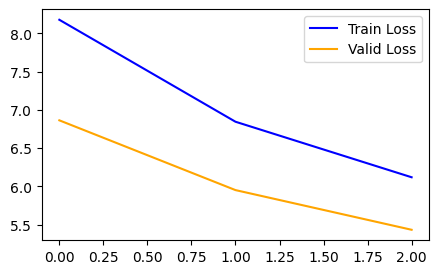

In [115]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')
plt.legend()
plt.show()


In [ ]:
#model save
save_path = 'sample_data/gen_attention.pt'
torch.save(model.state_dict(), save_path)



#### Training with Multiplicative Model

In [112]:
attention_variant = "Multiplicative Attention"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attentionn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attentionn_variant,
              device)

model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)

optimizer = optim.Adam(model_multiplicative.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model_multiplicative = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_multiplicative.apply(initialize_weights)


best_valid_loss = float('inf')
train_losses_multiplicative = []
valid_losses_multiplicative = []
print(f' Attention :{attention_variant} ')

total_epoch_time = 0

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model_multiplicative, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_multiplicative, valid_loader, criterion, val_loader_length)
    train_losses_multiplicative.append(train_loss)
    valid_losses_multiplicative.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} || Train PPL: {math.exp(train_loss):8.2f}')
    print(f'\tValidation Loss: {valid_loss:.3f} || Validation PPL: {math.exp(valid_loss):8.2f}')

final_train_loss = train_losses_multiplicative[-1]
final_valid_loss = valid_losses_multiplicative[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

print(f'Final Training Loss: {final_train_loss:.2f}')
print(f'Final Validation Loss: {final_valid_loss:.2f}')
print(f'Final Train PPL: {final_train_ppl:.2f}')
print(f'Final Validation PPL: {final_valid_ppl:.2f}')


 Attention :Multiplicative Attention 
	Train Loss: 8.193 || Train PPL:  3616.95
	Validation Loss: 6.867 || Validation PPL:   959.90
	Train Loss: 6.839 || Train PPL:   933.69
	Validation Loss: 5.986 || Validation PPL:   398.01
Final Training Loss: 6.84
Final Validation Loss: 5.99
Final Train PPL: 933.69
Final Validation PPL: 398.01


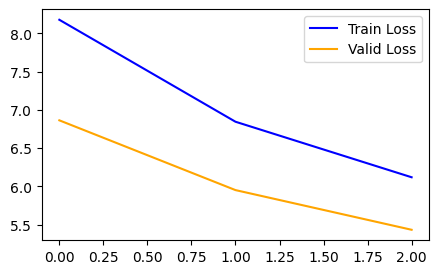

In [114]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')
plt.legend()
plt.show()


In [118]:
save_path = 'sample_data/mult_attention.pt'
torch.save(model.state_dict(), save_path)

#### Training with Additive Model

In [113]:
attention_variant = "Additive Attention"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attentionn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attentionn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n Attention : {attention_variant} ')

total_epoch_time = 0

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


print(f'Final Training Loss: {final_train_loss:.2f}')
print(f'Final Validation Loss: {final_valid_loss:.2f}')
print(f'Final Train PPL: {final_train_ppl:.2f}')
print(f'Final Validation PPL: {final_valid_ppl:.2f}')
###



 Attention : Additive Attention 
	Train Loss: 7.945 | Train PPL: 2820.441
	Val. Loss: 6.650 | Val. PPL: 772.965
	Train Loss: 6.625 | Train PPL: 753.334
	Val. Loss: 5.808 | Val. PPL: 332.823
Final Training Loss: 6.62
Final Validation Loss: 5.81
Final Train PPL: 753.33
Final Validation PPL: 332.82


In [117]:
save_path = 'sample_data/add_attention.pt'
torch.save(model.state_dict(), save_path)


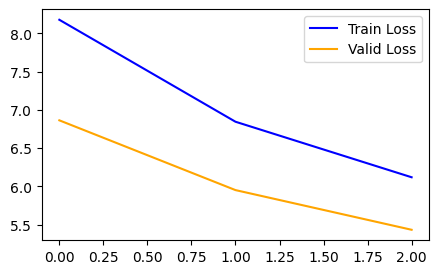

In [116]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')
plt.legend()
plt.show()
